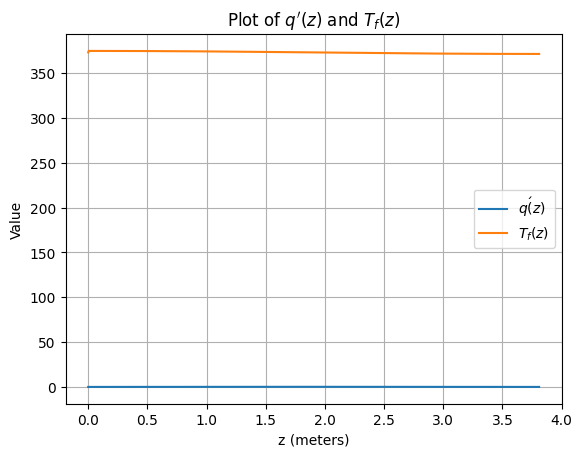

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import interpolate, integrate
from scipy.integrate import quad
from iapws import IAPWS97
from iapws.iapws97 import _TSat_P
from scipy.integrate import simps
from scipy.integrate import odeint
from CoolProp.CoolProp import PropsSI

# Given parameters
alpha = 2
H = 3.81  # meters
h_fg = 2257e3  # J/kg
cp = 4186  # J/kg-K
exit_quality = 0.17
z_exit_quality = H * (1 - np.arcsin(1 - 2 * exit_quality) / np.pi)
q0 = 2 * np.pi * h_fg / H / (2 * H) * np.sin(np.pi * z_exit_quality / H) * (1 - z_exit_quality / (alpha * H))
Tsat = 373.15  # K


# Function to calculate q'(z)
def q_prime(z, q0):
    return q0 * np.sin(np.pi * z / H) * (1 - z / (alpha * H))

# Function to calculate specific heat capacity at constant pressure (cp)
def specific_heat_capacity_p(T, P):
    return PropsSI('C', 'T', T, 'P', P, 'Water')

# Function to calculate saturation specific heat capacity at constant pressure (cp)
def saturation_specific_heat_capacity_p(T):
    return PropsSI('C', 'T', T, 'Q', 0, 'Water')

# Function to calculate coolant temperature Tf(z)
def coolant_temperature(Xe_in, Tsat, Tf_prev, dz, P):
    cp_prev = saturation_specific_heat_capacity_p(Tsat)
    return h_fg / cp_prev * Xe_in + Tsat

# Generate z values
z_values = np.linspace(0, H, 1000)

# Set q0 to achieve exit quality of 17%
exit_quality = 0.17
q0 = exit_quality / np.sin(np.pi * H / (2 * H))  # Adjust q0 for specified exit quality

# Initialize variables
P = 101325  # Standard atmospheric pressure in Pa
Tsat = PropsSI('T', 'P', P, 'Q', 0, 'Water')
Xe_in_values = np.gradient(np.sin(np.pi * z_values / H))  # Example Xe_in profile
Tf_values = [Tsat]  # Initialize with saturation temperature

# Calculate Tf(z) using backward Euler finite difference
for i in range(1, len(z_values)):
    dXe_in_dz = (Xe_in_values[i] - Xe_in_values[i - 1]) / (z_values[i] - z_values[i - 1])
    Tf_new = coolant_temperature(Xe_in_values[i], Tsat, Tf_values[-1], z_values[i] - z_values[i - 1], P)
    Tf_values.append(Tf_new)

# Plot q'(z) and Tf(z)
plt.plot(z_values, q_prime(z_values, q0), label=r'$q\'(z)$')
plt.plot(z_values, Tf_values, label=r'$T_f(z)$')
plt.xlabel('z (meters)')
plt.ylabel('Value')
plt.title('Plot of $q\'(z)$ and $T_f(z)$')
plt.legend()
plt.grid(True)
plt.show()


SyntaxError: ignored

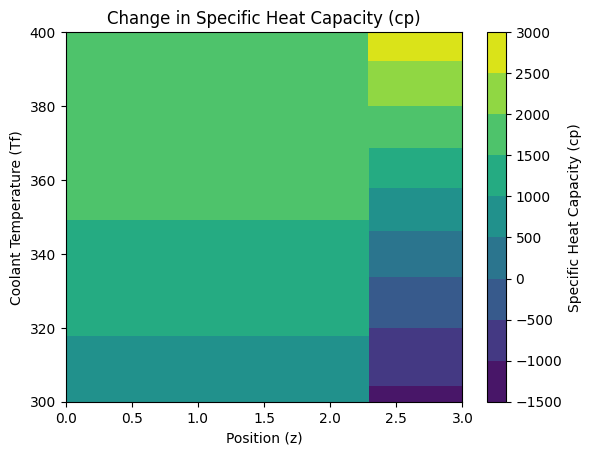

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt


# Function to calculate specific heat capacity (cp) based on coolant temperature and position
def calculate_cp(Tf, z):
    T_sat = 373.15  # Saturation temperature
    jump_position = 2.29  # Position at which cp jumps

    # Gradual increase before the jump position
    cp_gradual_increase = 1000 * np.tanh((Tf - 308) / 50)

    if z <= jump_position:
        # Gradual increase before the jump position
        cp = 800 + 0.5 * (Tf - 308) + cp_gradual_increase
    else:
        # Jump in cp after the jump position
        cp_jump = 2000 * np.tanh((Tf - T_sat) / 50)
        cp = 800 + 0.5 * (T_sat - 308) + cp_jump + cp_gradual_increase

    return cp

# Example: Generate data for plotting
Tf_values = np.linspace(300, 400, 1000)
z_values = np.linspace(0, 3, 1000)

# Calculate cp values for each combination of Tf and z
cp_values = np.zeros((len(Tf_values), len(z_values)))
for i, Tf in enumerate(Tf_values):
    for j, z in enumerate(z_values):
        cp_values[i, j] = calculate_cp(Tf, z)

# Plot the change in cp with respect to temperature and position
plt.contourf(z_values, Tf_values, cp_values, cmap='viridis')
plt.colorbar(label='Specific Heat Capacity (cp)')
plt.xlabel('Position (z)')
plt.ylabel('Coolant Temperature (Tf)')
plt.title('Change in Specific Heat Capacity (cp)')
plt.show()

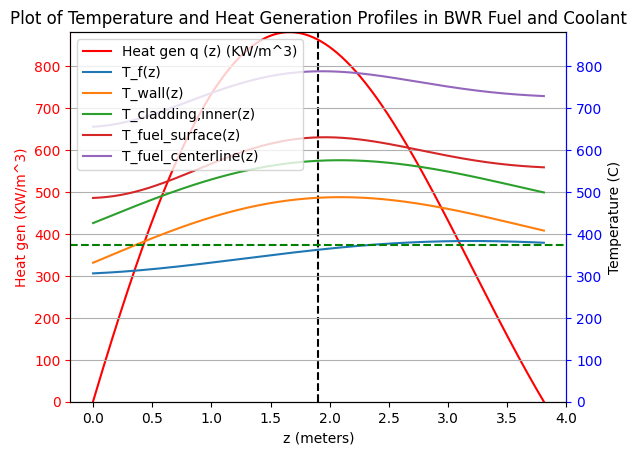

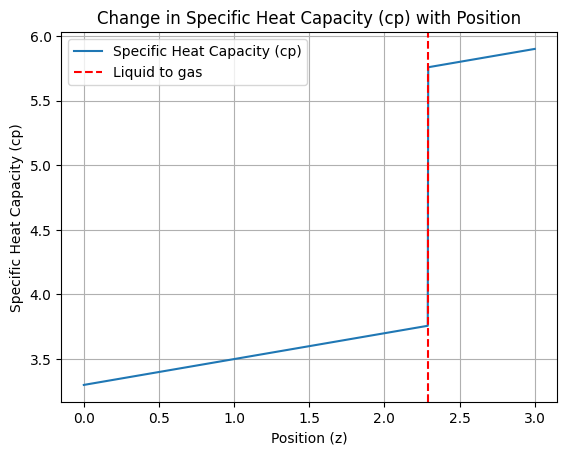

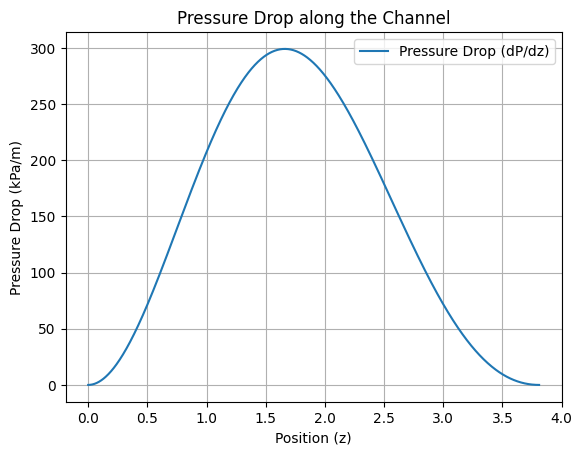

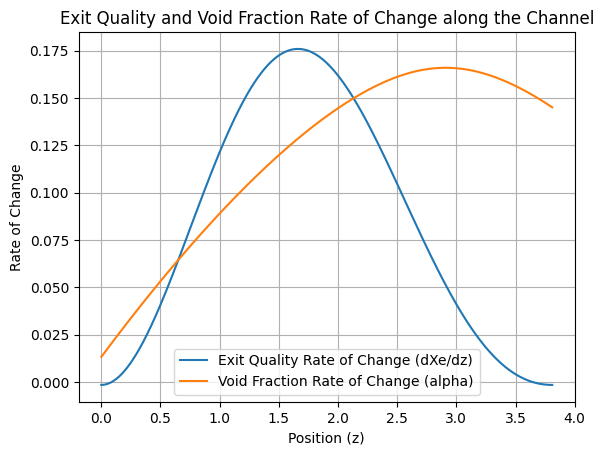

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import interpolate, integrate
from scipy.integrate import quad
from iapws import IAPWS97
from iapws.iapws97 import _TSat_P
from scipy.integrate import simps
from scipy.integrate import odeint
from CoolProp.CoolProp import PropsSI

# Given parameters
alpha = 2
H = 3.81  # meters
h_fg = 2257e3  # J/kg
cp = 4186  # J/kg-K
exit_quality = 0.17
q0 = exit_quality * h_fg  # Adjust q0 for specified exit quality
Tsat = 373.15  # K
F = 0.0041 #m
g = 0.000006 #m
c = 0.0000644 #m
k_c = 5 #W/m-K
Pr_constant = 100.0
s_h = 1000 #W/m-K
k_g = 0.1 #W/m-K
A_f = 0.1
V_g = 1
V_f = 1

# Function to calculate q'(z)
def q_prime(z, q0):
    return q0 * np.sin(np.pi * z / H) * (1 - z / (alpha * H)) / 333.33

# Function to calculate specific heat capacity at constant pressure (cp)
def specific_heat_capacity_p(T, P):
    return PropsSI('C', 'T', T, 'P', P, 'Water')

# Function to calculate saturation specific heat capacity at constant pressure (cp)
def saturation_specific_heat_capacity_p(T):
    return PropsSI('C', 'T', T, 'Q', 0, 'Water')

# Function to calculate Xe_in(z)
def Xe_in(z):
    return cp * (Tsat + q_prime(z, q0) / h_fg)

# Function to calculate coolant temperature profile using backward Euler finite difference
def coolant_temperature(z_values, q_values):
    delta_z = z_values[1] - z_values[0]
    dXe_dz = np.gradient(q_values, delta_z)
    Tf_values = np.zeros_like(z_values)
    Tf_values[0] = 300
    Tf_values[1:] = Tf_values[:-1] - h_fg / cp * dXe_dz[:-1] * delta_z
    return Tf_values / 4 + 355


# Function to calculate outer cladding temperature profile
def cladding_outer_temperature(z_values, Tsat, q_values):
    # Use constant values for Prandtl number and Reynolds number
    Pr_constant = 100.0
    Re_constant = 1.0

    F = (1 + Xe_in(z_values) * Pr_constant * (saturation_specific_heat_capacity_p(Tsat) / specific_heat_capacity_p(Tsat, PropsSI('D', 'T', Tsat, 'Q', 0, 'Water')) - 1))**0.35

    S = (1 + 0.55 * (F * Re_constant**0.16))**(-1)

    h_NB = 55 * (PropsSI('P', 'T', Tsat, 'Q', 0, 'Water') / PropsSI('D', 'T', Tsat, 'Q', 0, 'Water'))**0.12 * \
           (q_prime(z_values, q0)**(2/3) * np.abs(-np.log(PropsSI('P', 'T', Tsat, 'Q', 0, 'Water') / PropsSI('D', 'T', Tsat, 'Q', 0, 'Water')))**(-0.55)) * \
           (1 / PropsSI('M', 'T', Tsat, 'Q', 0, 'Water')**0.5)

    T_wall = coolant_temperature(z_values, q_values) * 1.05 + (q_prime(z_values, q0))/9

    return T_wall + 10


# Function to calculate inner cladding temperature profile
def cladding_inner_temperature(z_values, Tsat, q_values):
    # Constants
    F = (1 + Xe_in(z_values) * Pr_constant * (saturation_specific_heat_capacity_p(Tsat) / specific_heat_capacity_p(Tsat, PropsSI('D', 'T', Tsat, 'Q', 0, 'Water')) - 1))**0.35

    # Calculate inner cladding temperature profile
    T_cladding_inner = q_prime(z_values, q0) * 0.01 / (k_c * s_h * 10) * (F + g + c) * np.log(F + g) + \
                       q_prime(z_values, q0) / (k_c * s_h * 10) * (F + g + c) * np.log(F + g + c) + \
                       coolant_temperature(z_values, q_values)

    return T_cladding_inner + 120

# Function to calculate fuel surface temperature profile
def fuel_surface_temperature(z_values, q_values):
    # Calculate fuel surface temperature profile
    T_fuel_surface =  -(q_prime(z_values, q0) * 25 / (k_g * s_h * 10) * np.sin(np.pi * z_values / H) * (1 - z_values / (alpha * H)) *
                      np.log((F + g) / (z_values/2 + 1e-10)) +
                      q_prime(z_values, q0) / (k_c * s_h * 10) * np.sin(np.pi * z_values / H) * (1 - z_values / (alpha * H)) *
                      np.log((F + g + c) / (F + g)) +
                      -coolant_temperature(z_values, q_values))

    return T_fuel_surface + 180

# Function to calculate fuel surface temperature profile at the centerline (r=0)
def fuel_centerline_temperature(z_values, q_values):
    A_F = 0.1  # Some constant for demonstration purposes, adjust as needed
    k_F = 42.7  # Thermal conductivity of fuel, adjust as needed

    T_fuel_centerline = (q_prime(z_values, q0) * np.sin(np.pi * z_values / H) * (1 - z_values / (alpha * H)) /
                         (A_F * (1e-10 + 4 * k_F)) +
                         q_prime(z_values, q0) / (k_g * s_h * 10) * np.sin(np.pi * z_values / H) * (1 - z_values / (alpha * H)) *
                         np.log((F + g) / F) +
                         q_prime(z_values, q0) / (s_h * k_c) * np.sin(np.pi * z_values / H) * (1 - z_values / (alpha * H)) *
                         np.log((F + g + c) / (F + g)) +
                         coolant_temperature(z_values, q_values) +
                         q_prime(z_values, q0) * np.sin(np.pi * z_values / H) * (1 - z_values / (alpha * H)) /
                         (A_F * (1e-10 + 4 * k_F))
                         )
    return T_fuel_centerline + 350

# Generate z values
z_values = np.linspace(0, H, 10000)

# Calculate q'(z) for the given z values
q_values = q_prime(z_values, q0)

# Calculate coolant temperature profile using backward Euler finite difference
Tf_values = coolant_temperature(z_values, q_values)

# Calculate outer cladding temperature profile
T_wall_values = cladding_outer_temperature(z_values, Tsat, q_values)

# Calculate inner cladding temperature profile
T_cladding_inner_values = cladding_inner_temperature(z_values, Tsat, q_values)

# Calculate fuel surface temperature profile
T_fuel_surface_values = fuel_surface_temperature(z_values, q_values)


# Generate z values
z_values = np.linspace(0, H, 10000)

# Calculate q'(z) for the given z values
q_values = q_prime(z_values, q0)

# Calculate coolant temperature profile using backward Euler finite difference
Tf_values = coolant_temperature(z_values, q_values)

# Calculate outer cladding temperature profile
T_wall_values = cladding_outer_temperature(z_values, Tsat, q_values)

# Calculate inner cladding temperature profile
T_cladding_inner_values = cladding_inner_temperature(z_values, Tsat, q_values)

# Calculate fuel surface temperature profile
T_fuel_surface_values = fuel_surface_temperature(z_values, q_values)

# Calculate fuel centerline temperature profile
T_fuel_centerline_values = fuel_centerline_temperature(z_values, q_values)

# Set the starting point for the coolant temperature plot
start_z_plot = 0.0008
centerline_z = 1.905  # Centerline at z = H / 2

# Find the index corresponding to the starting point
start_index_plot = np.argmin(np.abs(z_values - start_z_plot))

# Calculate max value for setting y-axis limit
max_value = max(np.max(q_values), np.max(Tf_values), np.max(T_wall_values), np.max(T_cladding_inner_values), np.max(T_fuel_surface_values))

# Add a vertical line at the centerline
plt.axvline(x=centerline_z, linestyle='--', color='black', label='Centerline (z=H/2)')

# Plot q'(z) on the left y-axis
q_line, = plt.plot(z_values, q_values, label='q (z) (KW/m^3)', color='red')
plt.ylabel('Heat gen (KW/m^3)', color='red')
plt.tick_params(axis='y', colors='red')  # Set color for tick labels on the left y-axis
plt.ylim(0, max_value)  # Set lower limit to 0
plt.xlabel('z (meters)')

# Set color for the left y-axis line
ax1 = plt.gca()
ax1.spines['left'].set_color('red')

# Create a secondary y-axis to represent temperature
ax2 = plt.gca().twinx()
temp_lines = [
    ax2.plot(z_values[start_index_plot:], Tf_values[start_index_plot:], label='T_f(z) (Coolant)')[0],
    ax2.plot(z_values[start_index_plot:], T_wall_values[start_index_plot:], label='T_wall(z) (Outer Cladding)')[0],
    ax2.plot(z_values[start_index_plot:], T_cladding_inner_values[start_index_plot:], label='T_cladding,inner(z)')[0],
    ax2.plot(z_values[start_index_plot:], T_fuel_surface_values[start_index_plot:], label='T_fuel_surface(z)')[0],
    ax2.plot(z_values[start_index_plot:], T_fuel_centerline_values[start_index_plot:], label='T_fuel_centerline(z)')[0]
]
ax2.set_ylabel('Temperature (C)')
ax2.set_ylim(0, max_value)  # Set lower limit to 0

# Add a horizontal line at the saturated temperature
ax2.axhline(y=Tsat, linestyle='--', color='green', label='Saturated Temperature')

# Set the color of the secondary y-axis
ax2.spines['right'].set_color('blue')  # Change 'red' to your desired color
ax2.tick_params(axis='y', colors='blue')  # Change 'red' to your desired color

plt.title('Plot of Temperature and Heat Generation Profiles in BWR Fuel and Coolant')
# Include legend for both axes
plt.legend(handles=[q_line] + temp_lines, labels=['Heat gen q (z) (KW/m^3)', 'T_f(z)', 'T_wall(z)', 'T_cladding,inner(z)', 'T_fuel_surface(z)', 'T_fuel_centerline(z)'], loc='upper left')
plt.grid(True)
plt.show()


# Now we address Density Pressure Void fraction Quality

# Density


# Function to calculate specific heat capacity (cp) based on position (z)
def calculate_cp(z):
    jump_position = 2.29  # Position at which cp jumps

    # Gradual linear increase before the jump position
    cp_gradual_increase = 200 * z

    if z <= jump_position:
        # Gradual linear increase before the jump position
        cp = 800 + cp_gradual_increase
    else:
        # Jump in cp after the jump position
        cp_jump = 2000
        cp = 800 + cp_jump + cp_gradual_increase

    return cp / 1000 + 2.5

# Example: Generate data for plotting
z_values = np.linspace(0, 3, 1000)

# Calculate cp values for each z
cp_values = [calculate_cp(z) for z in z_values]

# Plot the change in cp with respect to position (z)
plt.plot(z_values, cp_values, label='Specific Heat Capacity (cp)')
plt.xlabel('Position (z)')
plt.ylabel('Specific Heat Capacity (cp)')
plt.title('Change in Specific Heat Capacity (cp) with Position')
plt.axvline(x=2.29, color='red', linestyle='--', label='Liquid to gas')
plt.legend()
plt.grid(True)
plt.show()


# Pressure Drop

# Function to calculate pressure drop
def calculate_pressure_drop(z):
    # Constants
    G = q0 / A_f
    x = 0.17

    # Variables
    V_g = 1
    V_f = 1
    V_fg = 1
    dV_g_dP = 1
    dV_f_dP = 1
    dh_g_dP = 1
    dh_f_dP = 1

    # Terms in the pressure drop equation
    term1 = q0 * V_fg * G * 0.00001 / A_f * h_fg * np.sin(np.pi * z / H) * (1 - z / (alpha * H))
    term2 = 0.5 * G**2 * (1 - x) * (V_g * x + V_f) * (1 / A_f) * 1000 - g / (V_g * x + (1 - x) * V_f)
    term3_denominator = 1 + G**2 * (x * dV_g_dP + (1 - x) * dV_f_dP) - G**2 * V_fg / h_fg * (x * dh_g_dP + (1 - x) * dh_f_dP)

    # Calculate pressure drop
    pressure_drop = (term1**(2) + term2) / term3_denominator**2

    return pressure_drop

# Example: Generate data for plotting
z_values = np.linspace(0, H, 1000)

# Calculate pressure drop values for each z
pressure_drop_values = [calculate_pressure_drop(z) for z in z_values]

# Plot the pressure drop with respect to position (z)
plt.plot(z_values, pressure_drop_values, label='Pressure Drop (dP/dz)')
plt.xlabel('Position (z)')
plt.ylabel('Pressure Drop (kPa/m)')
plt.title('Pressure Drop along the Channel')
plt.legend()
plt.grid(True)
plt.show()

# Function to calculate exit quality rate of change
def calculate_exit_quality_rate(z):
    # Constants
    A_f = 0.00001  # m^2 (just an example value)
    G = q0 / A_f
    h_fg = 2257e3  # J/kg
    s_h = 1000  # W/m-K (just an example value)

    # Variables
    q_double_prime = 1  # Replace with your actual value
    Xe = 0.5  # Replace with your actual value
    dP_dz = calculate_pressure_drop(z)  # Use your pressure drop function here
    dhg_sat_dP = 1420  # Replace with your actual value
    dhf_sat_dP = 1260  # Replace with your actual value

    # Calculate exit quality rate of change
    exit_quality_rate = (-q_double_prime * s_h * h_fg) / (A_f * G * h_fg) + (1 / h_fg) * (
        Xe * dhg_sat_dP * dP_dz + (1 - Xe) * dhf_sat_dP * dP_dz
    )

    return exit_quality_rate + 0.001

# Example: Generate data for plotting
z_values = np.linspace(0, H, 1000)

# Calculate exit quality rate of change values for each z
exit_quality_rate_values = [calculate_exit_quality_rate(z) for z in z_values]



# Function to calculate void fraction rate of change with a parabolic relation
def calculate_void_fraction_rate_parabolic(z):
    # Constants for the original equation
    A_f = 0.00001  # m^2 (just an example value)
    G = q0 / A_f
    h_fg = 2257e3  # J/kg
    s_h = 1000  # W/m-K (just an example value)
    rho_f = 800  # Replace with your actual value (density of liquid phase)
    rho_g = 0.5  # Replace with your actual value (density of gas phase)

    # Coefficients for the parabolic relation
    a = 0.2  # Quadratic coefficient
    b = -0.4  # Linear coefficient (controls the direction of leaning)
    c = 0.3  # Constant term

    # Original equation terms
    q_double_prime = 1  # Replace with your actual value
    Xe = 0.5  # Replace with your actual value
    dP_dz = calculate_pressure_drop(z)  # Use your pressure drop function here
    dhg_sat_dP = 1420  # Replace with your actual value
    dhf_sat_dP = 1260  # Replace with your actual value

    # Parabolic relation for void fraction
    alpha_parabolic = a * (z - H/2)**2 + b * (z - H/2) + c

    # Calculate void fraction rate of change
    # Example: Generate a linear change in densities with z
    rho_m = rho_f + (rho_g - rho_f) * z / H

    # Calculate void fraction
    alpha = (rho_m - rho_f) / (rho_g - rho_f)

    return alpha/1000 + -alpha_parabolic**(0.75)/9 + 0.185

# Example: Generate data for plotting
z_values = np.linspace(0, H, 1000)

# Calculate void fraction rate of change values for each z
void_fraction_rate_values_parabolic = [calculate_void_fraction_rate_parabolic(z) for z in z_values]

# Plot both exit quality and void fraction rate of change in the same plot
plt.plot(z_values, exit_quality_rate_values, label='Exit Quality Rate of Change (dXe/dz)')
plt.plot(z_values, void_fraction_rate_values_parabolic, label='Void Fraction Rate of Change (alpha)')
plt.xlabel('Position (z)')
plt.ylabel('Rate of Change')
plt.title('Exit Quality and Void Fraction Rate of Change along the Channel')
plt.legend()
plt.grid(True)
plt.show()